In [60]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
adata = sc.read_h5ad('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/1_raw_h5ad/Chen.MSI.raw.h5ad')

In [3]:
adata.obs['Identifier'] = [ f'{tup.SampleID}-{tup.Index.split("-")[0]}' for tup in adata.obs.itertuples() ]
adata.obs.shape[0] == len(set(adata.obs['Identifier']))

True

In [4]:
adata = adata[adata.obs['doublet_score']<=np.mean(adata.obs['doublet_score']) + 2*np.std(adata.obs['doublet_score'])].copy()

sc.pp.filter_cells(adata, min_genes=300)
sc.pp.filter_genes(adata, min_cells=10)

In [ ]:
adata.layers["counts"] = adata.X.copy()

In [6]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata.copy()
sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="SampleID")

In [7]:
adata = adata[:, adata.var.highly_variable]

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


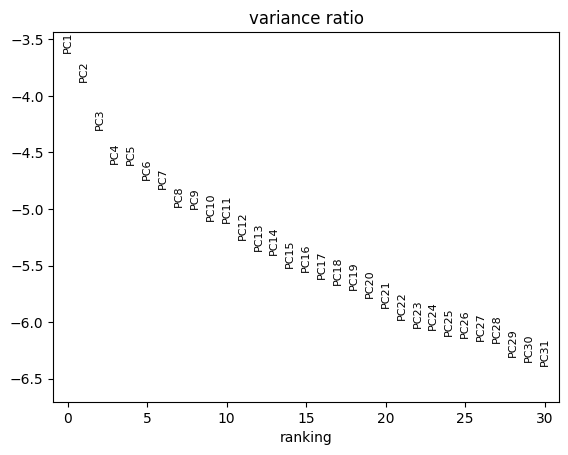

In [8]:
sc.pp.scale(adata, )
sc.tl.pca(adata, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata, log=True)

In [9]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata,)

2024-12-19 19:31:34.273832: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-19 19:31:34.275719: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-19 19:31:34.280170: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-19 19:31:34.295972: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-19 19:31:34.323400: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

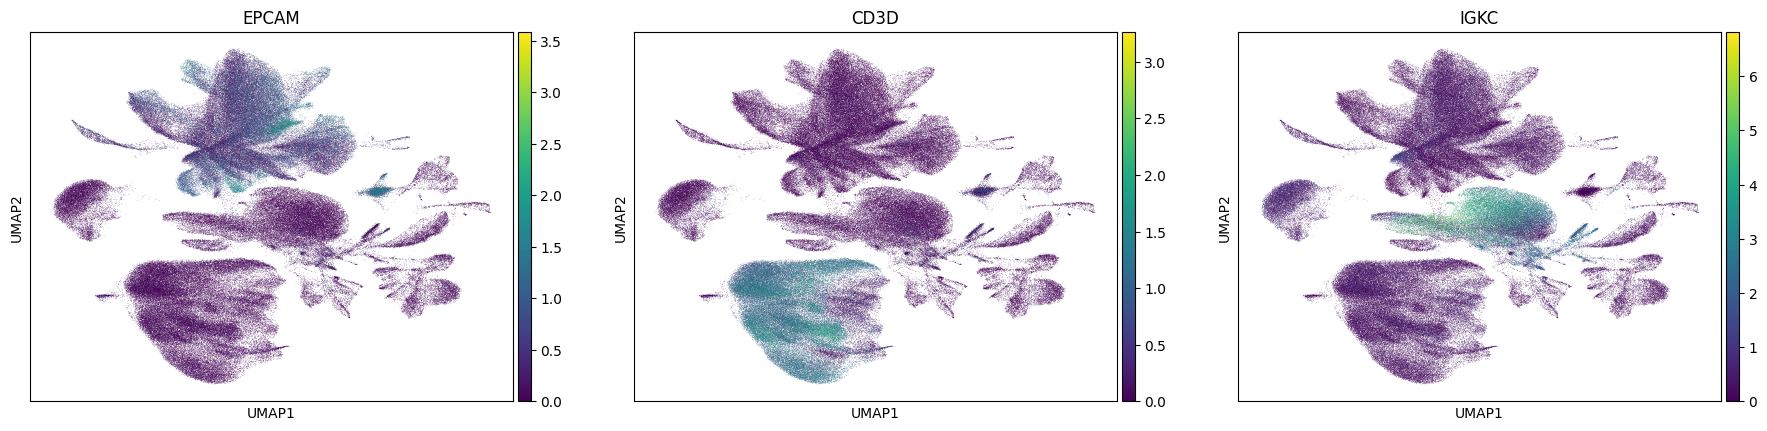

In [12]:
sc.pl.umap(adata, color=['EPCAM', 'CD3D', 'IGKC'], )

In [10]:
# import pandas as pd
# AlleleTable = pd.read_csv('/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/NanoMnT.AlleleTable.tsv.gz', sep='\t')

def saveWithPickle(obj, PATH_out, filename="saveWithPickle"):
    import pickle
    with open(f'{PATH_out}/{filename}.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def loadFromPickle(dir_pickle):
    import pickle
    with open(dir_pickle, 'rb') as handle:
        unserialized_pickle = pickle.load(handle)
    return unserialized_pickle

dict_NAT_Identifier_to_STRprofile   = loadFromPickle( '/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/NAT.dict_Identifier_to_STRprofile.pickle' )
dict_Tumor_Identifier_to_STRprofile = loadFromPickle( '/node200data/18parkky/datasets/data/public/processed_data/Immunotherapy_CRC_Chen_et_al/Tumor.dict_Identifier_to_STRprofile.pickle' )

In [21]:
dict_Identifier_to_STRprofile = dict()
for k, v in dict_Tumor_Identifier_to_STRprofile.items():
    dict_Identifier_to_STRprofile[k]=v
    
for k, v in dict_NAT_Identifier_to_STRprofile.items():
    dict_Identifier_to_STRprofile[k]=v

for Identifier in adata.obs['Identifier']:
    try: dict_Identifier_to_STRprofile[Identifier]
    except KeyError: dict_Identifier_to_STRprofile[Identifier]=[0, 0, 0]
    
adata.obs['AvgSTRDiff'] = [ dict_Identifier_to_STRprofile[Identifier][0] for Identifier in adata.obs['Identifier'] ]
adata.obs['StdSTRDiff'] = [ dict_Identifier_to_STRprofile[Identifier][1] for Identifier in adata.obs['Identifier'] ]
adata.obs['NumSTRLoci'] = [ dict_Identifier_to_STRprofile[Identifier][2] for Identifier in adata.obs['Identifier'] ]

In [24]:
sc.tl.leiden(adata, resolution=0.3,)

/tmp/ipykernel_241771/224990414.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.3,)


In [26]:
sc.tl.leiden(adata, resolution=0.1, key_added='leiden_res_0.1')

In [28]:
sc.tl.rank_genes_groups(adata, groupby='leiden_res_0.1',)

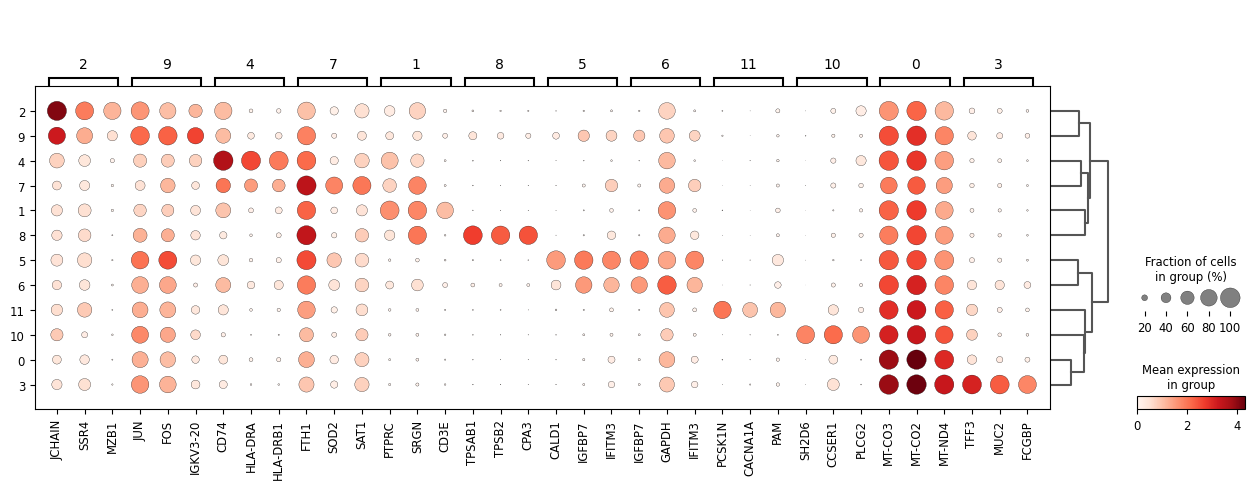

In [29]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=3)

In [41]:
adata_epi = adata[adata.obs['leiden_res_0.1'].isin(['0', '3', '6', '10', '11'])].raw.to_adata()

/home/18parkky/anaconda3-2021.11/envs/sc/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:316: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


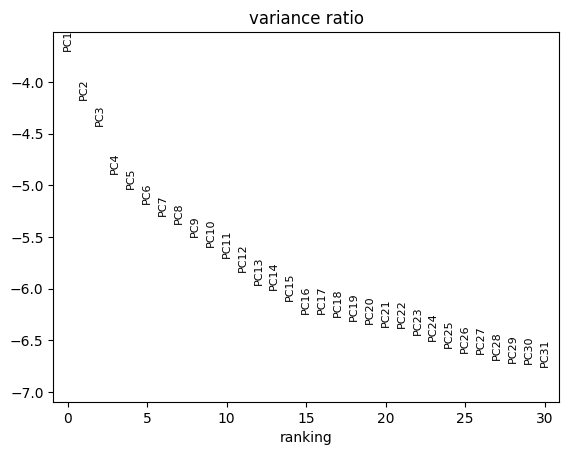

In [47]:
sc.pp.highly_variable_genes(adata_epi, n_top_genes=2000, batch_key="SampleID")
adata_epi = adata_epi[:, adata_epi.var.highly_variable]

sc.pp.scale(adata_epi, )
sc.tl.pca(adata_epi, svd_solver="arpack")
sc.pl.pca_variance_ratio(adata_epi, log=True)

In [48]:
sc.pp.neighbors(adata_epi, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata_epi,)

In [77]:
sc.tl.leiden(adata_epi, resolution=0.25, key_added='leiden_res_0.25')

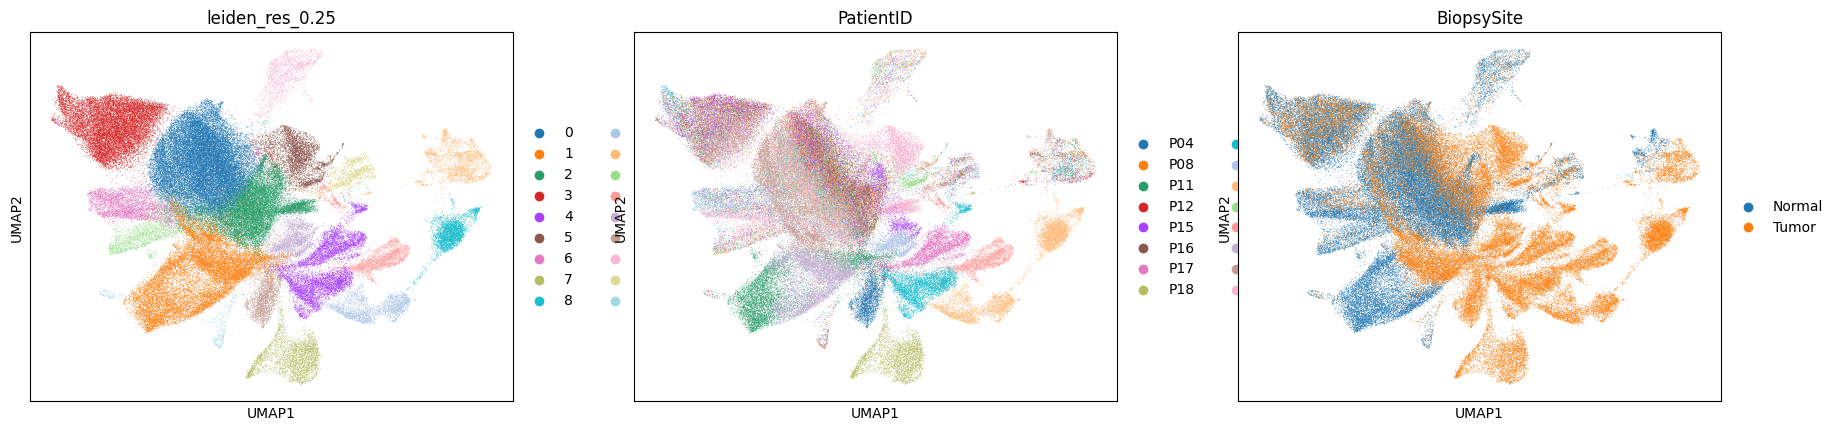

In [78]:
sc.pl.umap(adata_epi, color=['leiden_res_0.25', 'PatientID', 'BiopsySite'])

In [83]:
# Inspect patient-heterogeneity of each patient
l = list()

for leiden, edf in adata_epi.obs.groupby('leiden_res_0.25'):
    dict_SampleID_to_proportion = dict()
    for SampleID, edf2 in edf.groupby('SampleID'):
        dict_SampleID_to_proportion[SampleID] = len(edf2)/len(edf)
    dict_SampleID_to_proportion = dict(sorted(dict_SampleID_to_proportion.items(), key=lambda x:x[1], reverse=True))
    
    for SampleID, proportion in dict_SampleID_to_proportion.items():
        MajorSampleID = SampleID
        MajorProportion1 = proportion
        break 
    
    dict_BiopsySite_to_proportion = dict()
    for BiopsySite, edf2 in edf.groupby('BiopsySite'):
        dict_BiopsySite_to_proportion[BiopsySite] = len(edf2)/len(edf)
    
    print(f'{leiden}\t\t{round(100*MajorProportion1, 1)}\t\t\t{round(100*dict_BiopsySite_to_proportion['Normal'], 1)}\t\t{round(np.mean(edf[edf['NumSTRLoci']!=0]['AvgSTRDiff']), 1)}')
    l.append( [leiden, round(100*MajorProportion1, 1), round(100*dict_BiopsySite_to_proportion['Normal'], 1), round(np.mean(edf[edf['NumSTRLoci']!=0]['AvgSTRDiff']), 1)] )

l = pd.DataFrame(l, columns=['leiden', 'MajorPatientPerc', 'NormalSamplePerc', 'AvgSTRDiff'])

0		10.7			72.0		0.1
1		29.5			54.8		-0.7
2		25.9			74.2		-0.0
3		11.3			71.0		0.1
4		56.1			0.9		-1.3
5		70.3			6.0		-1.1
6		30.8			79.9		0.0
7		98.9			0.1		-0.7
8		99.3			0.1		-1.4
9		98.1			0.5		-2.1
10		11.1			27.8		0.1
11		20.9			89.9		0.1
12		95.8			1.8		-1.8
13		63.7			0.6		-1.4
14		94.3			0.6		-2.3
15		13.3			77.9		-0.0
16		8.5			53.9		-0.2
17		11.3			68.6		-0.3


/tmp/ipykernel_241771/3261238615.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for leiden, edf in adata_epi.obs.groupby('leiden_res_0.25'):
/tmp/ipykernel_241771/3261238615.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for SampleID, edf2 in edf.groupby('SampleID'):
/tmp/ipykernel_241771/3261238615.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for BiopsySite, edf2 in edf.groupby('BiopsySite'):


/tmp/ipykernel_241771/1068876810.py:3: UserWarning: 
The palette list has fewer values (14) than needed (18) and will cycle, which may produce an uninterpretable plot.
  f = sns.scatterplot(data=l, x='MajorPatientPerc', y='NormalSamplePerc', hue='leiden', palette=sns.color_palette('Paired', 8) + sns.color_palette('husl'), ax=axes[1], )


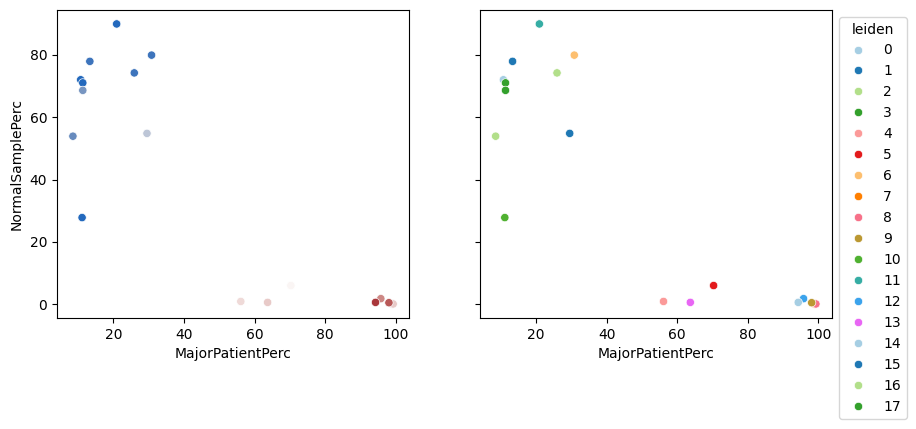

In [90]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
f = sns.scatterplot(data=l, x='MajorPatientPerc', y='NormalSamplePerc', hue='AvgSTRDiff', palette='vlag_r', legend=None, ax=axes[0])
f = sns.scatterplot(data=l, x='MajorPatientPerc', y='NormalSamplePerc', hue='leiden', palette=sns.color_palette('Paired', 8) + sns.color_palette('husl'), ax=axes[1], )
sns.move_legend(f, "upper left", bbox_to_anchor=(1, 1))

In [ ]:
""" 
0		10.7			72.0		0.1     N
1		29.5			54.8		-0.7    N
2		25.9			74.2		-0.0    N
3		11.3			71.0		0.1     N
4		56.1			0.9		-1.3        T
5		70.3			6.0		-1.1        T
6		30.8			79.9		0.0     N
7		98.9			0.1		-0.7        T
8		99.3			0.1		-1.4        T
9		98.1			0.5		-2.1        T
10		11.1			27.8		0.1     N
11		20.9			89.9		0.1     N
12		95.8			1.8		-1.8        T
13		63.7			0.6		-1.4        T
14		94.3			0.6		-2.3        T
15		13.3			77.9		-0.0    N
16		8.5			53.9		-0.2        N
17		11.3			68.6		-0.3    N
"""

In [92]:
dict_leiden_to_EpiCellType = {
    '0' : 'Normal epithelial',
    '1' : 'Normal epithelial',
    '2' : 'Normal epithelial',
    '3' : 'Normal epithelial',
    '6' : 'Normal epithelial',
    '10' : 'Normal epithelial',
    '11' : 'Normal epithelial',
    '15' : 'Normal epithelial',
    '16' : 'Normal epithelial',
    '17' : 'Normal epithelial',

    '4' : 'Tumor epithelial',
    '5' : 'Tumor epithelial',
    '7' : 'Tumor epithelial',
    '8' : 'Tumor epithelial',
    '9' : 'Tumor epithelial',
    '12' : 'Tumor epithelial',
    '13' : 'Tumor epithelial',
    '14' : 'Tumor epithelial',
}

adata_epi.obs['Manual_CellType_lvl_1'] = [ dict_leiden_to_EpiCellType[leiden] for leiden in adata_epi.obs['leiden_res_0.25'] ]

In [101]:
adata_epi_tumor = adata_epi[(adata_epi.obs['Manual_CellType_lvl_1']=='Tumor epithelial') & ~(adata_epi.obs['PatientID'].isin(['P11', 'P24']))].copy()

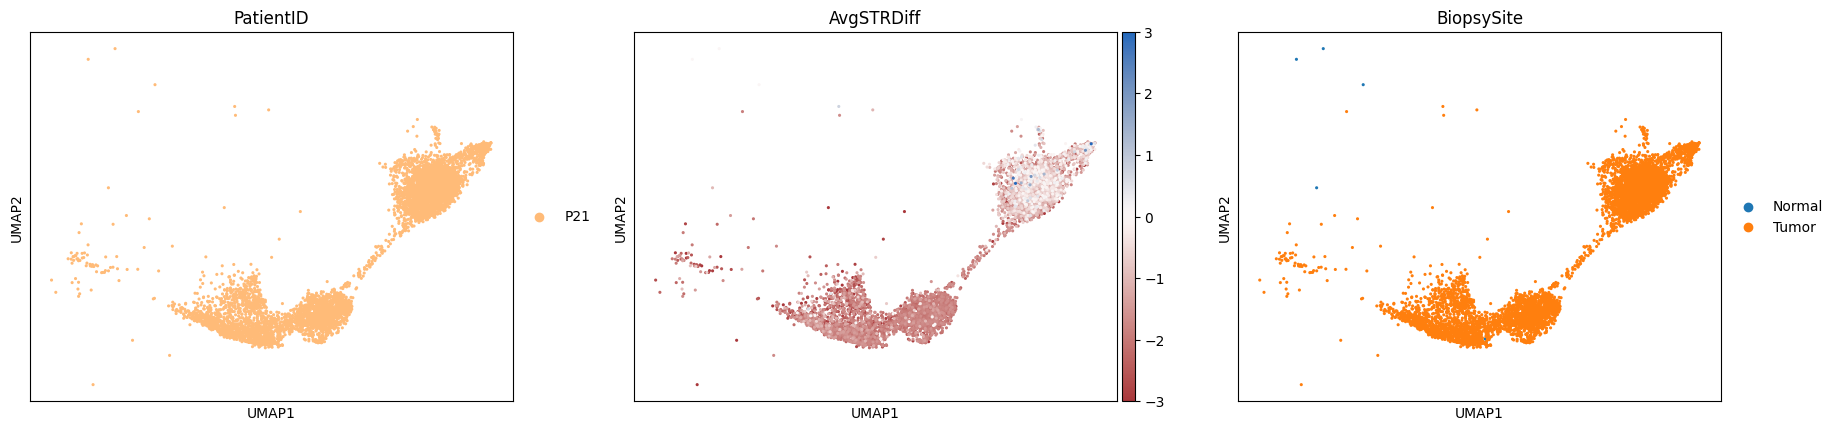

In [110]:
sc.pl.umap(adata_epi_tumor[adata_epi_tumor.obs['PatientID']=='P21'], color=['PatientID', 'AvgSTRDiff', 'BiopsySite'], cmap='vlag_r', vmin=-3, vmax=3)

<Axes: xlabel='AvgSTRDiff', ylabel='PatientID'>

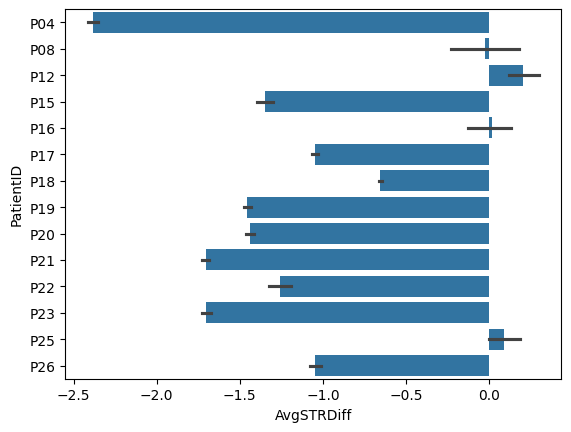

In [104]:
sns.barplot(data=adata_epi_tumor.obs, y='PatientID', x='AvgSTRDiff')